In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from uncertainties import unumpy as unp
import uncertainties
import seaborn as sb
import matplotlib.cm as cm
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats.mstats import gmean

1. Read the data

In [24]:
raw_data = pd.read_excel('data/RawData.xlsx')
raw_data = raw_data[~raw_data.units.str.contains('trap')]

In [3]:
raw_data.reference.nunique()

100

2. Focus on the mass data, and convert wet mass to dry mass, using a general *0.3 ratio

In [25]:
mass_data = raw_data[raw_data.units.str.startswith('mg')]
mass_data['norm value'] = mass_data['numerical value']
mass_data.loc[mass_data.units=='mg/m^2 (wet weight)','norm value'] = mass_data.loc[mass_data.units=='mg/m^2 (wet weight)','norm value']*0.3 #convert the wet mass to an effective dry mass, by multiplying by 0.3

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


3. Remove partial measurements

In [26]:
metadata = pd.read_csv('data/groups_per_reference.csv')
mass_data_with_meta = mass_data.merge(metadata,left_on='reference', right_on='Paper',how='left')

In [6]:
mass_data_with_meta.groupby('Standard groups')['site'].nunique()

Standard groups
Acari                  9
Arthropods           174
Collembola, Acari     48
Formicidae            49
Isoptera              12
Macroarthropods       25
Microarthropods        2
Orthoptera             1
Some arthropods        4
Name: site, dtype: int64

In [29]:
raw_data_with_meta = raw_data.merge(metadata,left_on='reference', right_on='Paper',how='left')
raw_data_val = raw_data_with_meta[(raw_data_with_meta['Standard groups']!='Microarthropods') | ((raw_data_with_meta['Standard groups']=='Microarthropods') & (raw_data_with_meta['sub-class'].isin(['Acari','Collembola'])))]
raw_data_val = raw_data_val[~raw_data_val['Standard groups'].isna()]
raw_data_val.groupby(['aggregated environment']).site.nunique()

aggregated environment
above ground     34
plants           51
soil/litter     300
Name: site, dtype: int64

In [30]:
valid_data = mass_data_with_meta.copy()
valid_data = valid_data[(valid_data['Standard groups']!='Microarthropods') | ((valid_data['Standard groups']=='Microarthropods') & (valid_data['sub-class'].isin(['Acari','Collembola'])))]

4. Classify into groups using "aggregated taxon" and "aggregated environment"

In [31]:
valid_data.loc[valid_data['sub-class']=='Acari','aggregated taxon'] = 'Acari'
valid_data.loc[valid_data['sub-class']=='Collembola','aggregated taxon'] = 'Collembola'
valid_data.loc[valid_data['super-family']=='Isoptera','aggregated taxon'] = 'Isoptera'
valid_data.loc[valid_data['family']=='Formicidae','aggregated taxon'] = 'Formicidae'
valid_data.loc[valid_data['aggregated taxon'].isna(),'aggregated taxon'] = 'Other'

In [32]:
soil_data = valid_data[valid_data['aggregated environment'] =='soil/litter']
canopy_data = valid_data[valid_data['aggregated environment'] =='plants']
surface_data = valid_data[valid_data['aggregated environment'] =='above ground']

In [33]:
soil_data.pivot_table(columns='aggregated taxon',values='site',index='aggregated biome', aggfunc='nunique')

aggregated taxon,Acari,Collembola,Formicidae,Isoptera,Other
aggregated biome,,,,,
Boreal Forests/Taiga,22.0,21.0,NaN,NaN,16.0
Crops,NaN,NaN,6.0,29.0,9.0
Deserts and Xeric Shrublands,1.0,1.0,4.0,1.0,NaN
"Mediterranean Forests, Woodlands and Scrub",NaN,NaN,1.0,2.0,NaN
Pasture,7.0,7.0,7.0,20.0,10.0
Shrubland/Grassland,NaN,NaN,13.0,NaN,NaN
Temperate Forests,46.0,43.0,25.0,6.0,31.0
"Temperate Grasslands, Savannas and Shrublands",17.0,18.0,10.0,2.0,16.0
Tropical and Subtropical Forests,5.0,6.0,21.0,40.0,19.0


In [34]:
# placeholder for ants
#shrub_index = soil_data.loc[(soil_data['family'] == 'Formicidae') & (soil_data['aggregated biome'] == 'Shrubland/Grassland')].index
#soil_data.loc[shrub_index[0:8],'aggregated biome'] = 'Temperate Grasslands, Savannas and Shrublands'
#soil_data.loc[shrub_index[8:],'aggregated biome'] = 'Tropical and Subtropical Grasslands, Savannas and Shrublands'

soil_data = soil_data[soil_data['aggregated biome'] != 'Shrubland/Grassland']#Drop the ants measurements with unknown biomes

In [15]:
#soil_site_data = soil_data.groupby(['aggregated taxon','aggregated biome','site'])['norm value'].sum()
#soil_biome_means = soil_site_data.groupby(['aggregated taxon','aggregated biome']).agg(['mean','count','sem'])
#soil_biome_means.reset_index().pivot_table(columns='aggregated taxon',index='aggregated biome').to_csv('results/biome_means.csv')

#soil_biome_means['umean'] = unp.uarray(nominal_values=soil_biome_means['mean'],std_devs=soil_biome_means['sem'])
#soil_biome_means = soil_biome_means[['count','umean']]
#soil_biome_means

count  \
aggregated taxon aggregated biome                                            
Acari            Boreal Forests/Taiga                                   20   
                 Deserts and Xeric Shrublands                            1   
                 Pasture                                                 7   
                 Temperate Forests                                      42   
                 Temperate Grasslands, Savannas and Shrublands          15   
                 Tropical and Subtropical Forests                        5   
                 Tropical and Subtropical Grasslands, Savannas a...      2   
                 Tundra                                                 47   
Collembola       Boreal Forests/Taiga                                   19   
                 Deserts and Xeric Shrublands                            1   
                 Pasture                                                 7   
                 Temperate Forests                                      41   
                 Temperate Grasslands, Savannas and Shrublands          17   
                 Tropical and Subtropical Forests                        6   
                 Tropical and Subtropical Grasslands, Savannas a...      2   
                 Tundra                                                 34   
Formicidae       Crops                                                   6   
                 Deserts and Xeric Shrublands                            4   
                 Pasture                                                 6   
                 Temperate Forests                                      21   
                 Temperate Grasslands, Savannas and Shrublands          17   
                 Tropical and Subtropical Forests                       20   
                 Tropical and Subtropical Grasslands, Savannas a...      9   
                 Tundra                                                  1   
Isoptera         Crops                                                  10   
                 Deserts and Xeric Shrublands                            5   
                 Mediterranean Forests, Woodlands and Scrub              2   
                 Pasture                                                 5   
                 Temperate Forests                                       1   
                 Temperate Grasslands, Savannas and Shrublands           4   
                 Tropical and Subtropical Forests                       20   
                 Tropical and Subtropical Grasslands, Savannas a...     10   
                 Tundra                                                  1   
Other            Boreal Forests/Taiga                                   16   
                 Crops                                                   6   
                 Pasture                                                 5   
                 Temperate Forests                                      29   
                 Temperate Grasslands, Savannas and Shrublands          15   
                 Tropical and Subtropical Forests                       15   
                 Tropical and Subtropical Grasslands, Savannas a...      4   
                 Tundra                                                 14   

                                                                                        umean  
aggregated taxon aggregated biome                                                              
Acari            Boreal Forests/Taiga                                         (5.1+/-1.0)e+02  
                 Deserts and Xeric Shrublands                        109.74000000000001+/-nan  
                 Pasture                                                          (6+/-6)e+02  
                 Temperate Forests                                            (7.8+/-1.7)e+02  
                 Temperate Grasslands, Savannas and Shrublands                (3.2+/-0.8)e+02  
                 Tropical and Subtropical 

In [147]:
def LogMean(x , kk = 1 , scale = 1): #returns the mean, lower, and upper standart errors based on a log transform with parameter kk (default = 1). Scale changes the units used, such that the effect of kk can be reduced
    if kk == 0 or len(x) < 2:
        return  gmean(x), 0 , 0
    else:    
        Xlog = np.log10(scale*x + kk)
        fitting_params = scipy.stats.norm.fit(Xlog, loc=np.mean(Xlog))
        norm_dist_fitted = scipy.stats.norm(*fitting_params)
        return (10**norm_dist_fitted.mean()-kk)/scale , (10**(norm_dist_fitted.mean()-norm_dist_fitted.std())-kk)/scale ,(10**(norm_dist_fitted.mean()+norm_dist_fitted.std())-kk)/scale


    
def calc_uval(x):
    return unp.uarray(nominal_values=np.mean(x),std_devs=x.sem())

def calc_uval_log(x):
    return LogMean(x,kk = 1,scale = 1e6)[0]


soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
soil_site_data = soil_site_taxa_mean.groupby(['aggregated taxon','aggregated biome','site'])['norm value'].sum()
soil_biome_means = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='norm value', aggfunc=[calc_uval,'count'])

soil_biome_means_log = soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='norm value', aggfunc=[calc_uval_log,'count'])

soil_biome_means = soil_biome_means.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
soil_biome_means.columns = soil_biome_means.columns.set_levels(['mean','N'],1)

soil_biome_means_log = soil_biome_means_log.unstack().reset_index().pivot_table(index='aggregated taxon', columns=['aggregated biome','level_0'],values=0,aggfunc=sum)
soil_biome_means_log.columns = soil_biome_means_log.columns.set_levels(['mean','N'],1)

def print_u(x):
    if type(x) != uncertainties.core.Variable:
        return '{:.0f}'.format(x )
    else: 
        return '{:.0f}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

soil_biome_means_print = soil_biome_means.applymap(print_u)
soil_biome_means_log_print = soil_biome_means_log.applymap(print_u)

#soil_biome_means_print.to_csv('results/table_1.csv')  #uncomment

In [113]:
soil_biome_means_print

aggregated biome Boreal Forests/Taiga         Crops      \
level_0                          mean   N      mean   N   
aggregated taxon                                          
Acari                          377±63  22         0   0   
Collembola                    443±248  21         0   0   
Formicidae                          0   0     49±17   6   
Isoptera                            0   0  1486±359  29   
Other                          264±62  16  1129±469   9   

aggregated biome Deserts and Xeric Shrublands     \
level_0                                  mean  N   
aggregated taxon                                   
Acari                                   9±nan  1   
Collembola                              1±nan  1   
Formicidae                              72±37  4   
Isoptera                              246±nan  1   
Other                                       0  0   

aggregated biome Mediterranean Forests, Woodlands and Scrub     Pasture      \
level_0                                                mean  N     mean   N   
aggregated taxon                                                              
Acari                                                     0  0    43±41   7   
Collembola                                                0  0      4±4   7   
Formicidae                                           39±nan  1   129±32   7   
Isoptera                                           1200±390  2  619±273  20   
Other                                                     0  0  751±208  10   

aggregated biome Temperate Forests      \
level_0                       mean   N   
aggregated taxon                         
Acari                      862±208  46   
Collembola                  299±94  43   
Formicidae                 717±629  25   
Isoptera                   409±262   6   
Other                     1061±184  31   

aggregated biome Temperate Grasslands, Savannas and Shrublands      \
level_0                                                   mean   N   
aggregated taxon                                                     
Acari                                                   279±75  17   
Collembola                                              179±46  18   
Formicidae                                             280±163  10   
Isoptera                                               780±780   2   
Other                                                  655±235  16   

aggregated biome Tropical and Subtropical Forests      \
level_0                                      mean   N   
aggregated taxon                                        
Acari                                      162±83   5   
Collembola                                  49±28   6   
Formicidae                                 140±74  21   
Isoptera                                 2540±727  40   
Other                                     812±226  19   

aggregated biome Tropical and Subtropical Grasslands, Savannas and Shrublands  \
level_0                                                                  mean   
aggregated taxon                                                                
Acari                                                         74±47             
Collembola                                                     12±1             
Formicidae                                                   398±53             
Isoptera                                                   1394±570             
Other                                                       165±142             

aggregated biome       Tundra      
level_0            N     mean   N  
aggregated taxon                   
Acari              2   212±42  48  
Collembola         2  388±146  35  
Formicidae         3    0±nan   1  
Isoptera          15    0±nan   1  
Other              5    64±36  14

In [141]:
soil_biome_means_log_print

aggregated biome Boreal Forests/Taiga     Crops      \
level_0                          mean   N  mean   N   
aggregated taxon                                      
Acari                             252  22     0   0   
Collembola                        132  21     0   0   
Formicidae                          0   0     8   6   
Isoptera                            0   0   436  29   
Other                              73  16   655   9   

aggregated biome Deserts and Xeric Shrublands     \
level_0                                  mean  N   
aggregated taxon                                   
Acari                                       9  1   
Collembola                                  1  1   
Formicidae                                 41  4   
Isoptera                                  246  1   
Other                                       0  0   

aggregated biome Mediterranean Forests, Woodlands and Scrub    Pasture      \
level_0                                                mean  N    mean   N   
aggregated taxon                                                             
Acari                                                     0  0       1   7   
Collembola                                                0  0       0   7   
Formicidae                                               39  1     101   7   
Isoptera                                               1135  2      74  20   
Other                                                     0  0     325  10   

aggregated biome Temperate Forests      \
level_0                       mean   N   
aggregated taxon                         
Acari                          324  46   
Collembola                     119  43   
Formicidae                      61  25   
Isoptera                        10   6   
Other                          677  31   

aggregated biome Temperate Grasslands, Savannas and Shrublands      \
level_0                                                   mean   N   
aggregated taxon                                                     
Acari                                                      105  17   
Collembola                                                  60  18   
Formicidae                                                 120  10   
Isoptera                                                    31   2   
Other                                                      121  16   

aggregated biome Tropical and Subtropical Forests      \
level_0                                      mean   N   
aggregated taxon                                        
Acari                                          96   5   
Collembola                                     29   6   
Formicidae                                     43  21   
Isoptera                                      534  40   
Other                                         279  19   

aggregated biome Tropical and Subtropical Grasslands, Savannas and Shrublands  \
level_0                                                                  mean   
aggregated taxon                                                                
Acari                                                            57             
Collembola                                                       12             
Formicidae                                                      390             
Isoptera                                                        459             
Other                                                            17             

aggregated biome     Tundra      
level_0            N   mean   N  
aggregated taxon                 
Acari              2    113  48  
Collembola         2    117  35  
Formicidae         3      0   1  
Isoptera          15      0   1  
Other              5     22  14

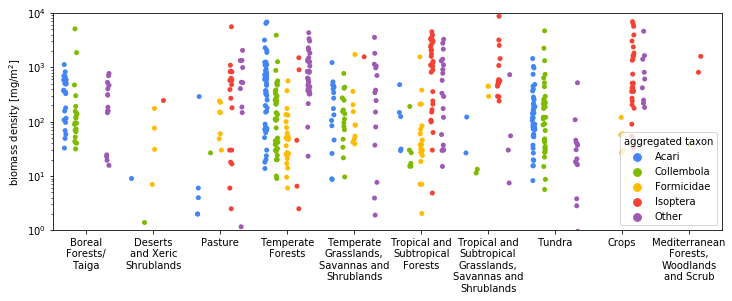

In [148]:
pal = sb.color_palette(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'])
r = soil_site_data.reset_index()

original_biomes = r['aggregated biome'].unique()
# r.repl
print_biomes = ['Boreal\nForests/\nTaiga','Deserts\nand Xeric\nShrublands','Pasture','Temperate\nForests','Temperate\nGrasslands,\nSavannas and\nShrublands','Tropical and\nSubtropical\nForests','Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands','Tundra','Crops','Mediterranean\nForests,\nWoodlands\nand Scrub']
r2 = r.replace(to_replace=original_biomes,value=print_biomes)
fig,ax = plt.subplots(figsize=[12,4])
sb.stripplot(x='aggregated biome',y='norm value',hue='aggregated taxon',data=r2,dodge=True,palette=pal,ax=ax)
ax.set_yscale('log')
ax.set_ylim([1,10000])
ax.set_ylabel('biomass density [mg/m$^2$]')
ax.set_xlabel('')
plt.savefig('results/test_fig2.svg',dpi=300)


In [149]:
def legend_without_duplicate_labels(ax,pos):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),bbox_to_anchor=pos)

In [165]:
Isoptera_data = pd.read_excel('data/IsopteraData.xlsx')

/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/Yuvalr/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:324: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


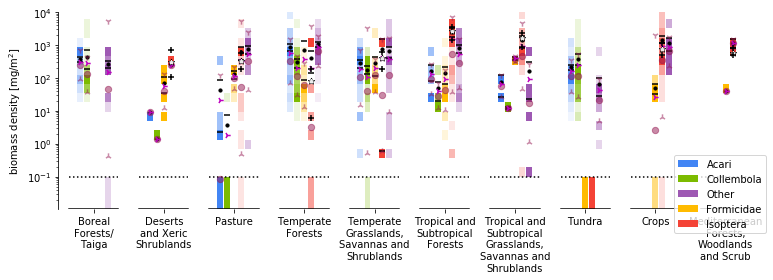

In [362]:
r = soil_site_data.reset_index()
original_biomes = r['aggregated biome'].unique()
# r.repl
print_biomes = ['Boreal\nForests/\nTaiga','Deserts\nand Xeric\nShrublands','Pasture','Temperate\nForests','Temperate\nGrasslands,\nSavannas and\nShrublands','Tropical and\nSubtropical\nForests','Tropical and\nSubtropical\nGrasslands,\nSavannas and\nShrublands','Tundra','Crops','Mediterranean\nForests,\nWoodlands\nand Scrub']
r2 = r.replace(to_replace=original_biomes,value=print_biomes)

r4 = r2.loc[r2['norm value']>=0] ###
#r5 = r2.loc[r2['norm value']>0]
bins = np.logspace(-1,np.log10(r4['norm value'].max()),20)
bins = np.insert(bins,0,-0.1) #add the point -0.1 to the beginning of the bins array
#bins = np.logspace(r4['norm value'].min(),r4['norm value'].max(),20)   
t = r4.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index()
y = t.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(np.max).reset_index()
t3 = t.merge(y,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon'])
t3['val'] = t3['norm value_x']/t3['norm value_y']


Isoptra = Isoptera_data.replace(to_replace=original_biomes,value=print_biomes)


fig,ax=plt.subplots(figsize=[11,4])
def print_data(x):
    col_map = pd.Series(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    if x['val'].values[0] == 1:
        lab = x['aggregated taxon'].values[0]
    else:
        lab=None
    plt.bar(x=xloc,
            height=x['level_2'].values[0].right-x['level_2'].values[0].left,
            width=0.17,
            bottom=x['level_2'].values[0].left,
            log=True,color=col,alpha=x['val'].values[0],
            label=lab,
            zorder=1
           )
def print_mean_median(x):
    col_map = pd.Series(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Mean = x['norm value'].mean()
    SEM = x['norm value'].sem()
    Y = (Mean, Mean - SEM , Mean + SEM)
    plt.scatter(x=xloc,y=Y[0],marker='.',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[1],marker='_',c='k',s=40,zorder=3)
    plt.scatter(x=xloc,y=Y[2],marker='_',c='k',s=40,zorder=3)
    
    
def print_mean_log(x):
    col_map = pd.Series(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    fine_loc = pd.Series([-0.4,-0.2,0,0.2,0.4],index=['Acari','Collembola','Formicidae','Isoptera','Other'])
    col = col_map.loc[x['aggregated taxon'].values[0]]
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc.loc[x['aggregated taxon'].values[0]]
    Y = LogMean(x['norm value'],kk = 1,scale = 1e6)
    plt.scatter(x=xloc,y= Y[0],marker='o',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[1],marker='2',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= Y[2],marker='1',c='#941751', alpha=0.5,s=40,zorder=4)
    plt.scatter(x=xloc,y= (Y[0]+x['norm value'].mean())/2,marker='4',c='m', alpha=1,s=40,zorder=4)
    
    
#Print fine average of Isoptera
def print_mean_Isoptera(x):
    fine_loc = 0.2;
    locs = pd.Series(range(0,2*len(r4['aggregated biome'].unique()),2),index=r4['aggregated biome'].unique())
    xloc = locs.loc[x['aggregated biome'].values[0]] + fine_loc
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['Mid estimate'],marker='*',c='#EBEBEB', alpha=1,s=15,zorder=4)
    plt.scatter(x=xloc,y=x['Low estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)
    plt.scatter(x=xloc,y=x['High estimate'],marker='+',c='k', alpha=1,s=40,zorder=4)

    
    
    
#     if x['val'].values[0] >0:
#         plt.plot([xloc-0.17/2,xloc+0.17/2],[x['level_2'].values[0].right,x['level_2'].values[0].right],color='k',linewidth=0.7,alpha=1)
for i in range(0,2*len(r4['aggregated biome'].unique()),2):    
    plt.plot([i-0.7,i+0.7],[1.01e-2,1.01e-2],'k')   #plot lines for labels
    plt.plot([i-0.7,i+0.7],[1e-1,1e-1],'k:')        #plot dotted lines for breaking points

ax = t3.groupby(['aggregated biome','aggregated taxon','level_2']).apply(print_data)
ax = plt.gca()
ax.set_xticks(range(0,2*len(r4['aggregated biome'].unique()),2))
ax.set_xticklabels(r4['aggregated biome'].unique())
###Set the y ticks to include the 0... 
ax.get_label()
ax.set_ylabel('biomass density [mg/m$^2$]')
# plt.legend()
ax.set_ylim([1.01e-2,1e4])
ax.set_xlim([-1,19])
legend_without_duplicate_labels(ax,(0.87,0.3))
sb.despine(top=True, bottom=True, right=True)
r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_median)
r4.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_log)
Isoptra.groupby(['aggregated biome','aggregated taxon']).apply(print_mean_Isoptera)

plt.tight_layout()



# axins = inset_axes(ax,
#                    width="1.3%",  # width = 5% of parent_bbox width
#                    height="35%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.02, 0.05, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0,
#                    )

# cmap = plt.get_cmap('Greys', 10)
# cbar = cm.ScalarMappable(cmap=cmap)
# cbar.set_array(np.array([0,1]))
# cb = fig.colorbar(cbar, cax=axins,shrink=0.4,ticks=[0,1],aspect=10)
# cb.ax.set_yticklabels(['least frequent','most frequent'])
# cb.outline.set_visible(False)


#plt.savefig('results/fig_test_1.svg',dpi=300)  #Uncomment later
plt.savefig('results/fig_test_1.pdf',dpi=300)  #Uncomment later






[Text(1, 0, 'min'), Text(1, 0, 'max')]

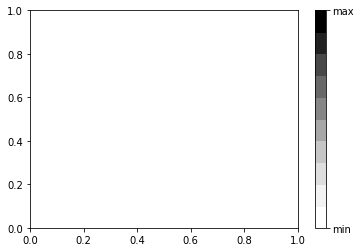

In [55]:
# cm.ScalarMappable()
cmap = plt.get_cmap('Greys', 10)
cbar = cm.ScalarMappable(cmap=cmap)
cbar.set_array(np.array([0,1]))
cb = plt.colorbar(cbar,ticks=[0,1],anchor=(0,0.5))
cb.ax.set_yticklabels(['min','max'])


In [2]:
plt.get_cmap()

In [187]:
r4 = r2.loc[r2['norm value']>0]
t = r4.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(lambda x: pd.cut(x,bins=bins).value_counts()/len(x)).reset_index()
u = t.loc[0,'level_2']
t2 = t.groupby(['aggregated biome','aggregated taxon','level_2']).apply(lambda x: print(x['norm value'].values[0])).reset_index()
t2

y = t.groupby(['aggregated biome','aggregated taxon'])['norm value'].apply(np.max).reset_index()
t3 = t.merge(y,left_on=['aggregated biome','aggregated taxon'],right_on=['aggregated biome','aggregated taxon'])
t3['val'] = t3['norm value_x']/t3['norm value_y']
t3

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.05
0.15
0.15
0.1
0.05
0.3
0.15
0.05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.15789473684210525
0.15789473684210525
0.2631578947368421
0.21052631578947367
0.05263157894736842
0.05263157894736842
0.0
0.0
0.05263157894736842
0.0
0.05263157894736842
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.26666666666666666
0.0
0.0
0.0
0.26666666666666666
0.13333333333333333
0.2
0.13333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.4
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.2
0.1
0.1
0.2
0.2
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.16666666666666666
0.3333333333333333
0.16666666666666666
0.16666666666666666
0.16666666666666666
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.25
0.0
0.0
0.25
0.0
0.25
0.25
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


,index


,aggregated biome,aggregated taxon,level_2,norm value_x,norm value_y,val
0,Boreal\nForests/\nTaiga,Acari,"(348.417, 587.495]",0.300000,0.300000,1.000000
1,Boreal\nForests/\nTaiga,Acari,"(43.1, 72.675]",0.150000,0.300000,0.500000
2,Boreal\nForests/\nTaiga,Acari,"(587.495, 990.625]",0.150000,0.300000,0.500000
3,Boreal\nForests/\nTaiga,Acari,"(72.675, 122.543]",0.150000,0.300000,0.500000
4,Boreal\nForests/\nTaiga,Acari,"(122.543, 206.63]",0.100000,0.300000,0.333333
5,Boreal\nForests/\nTaiga,Acari,"(990.625, 1670.377]",0.050000,0.300000,0.166667
6,Boreal\nForests/\nTaiga,Acari,"(206.63, 348.417]",0.050000,0.300000,0.166667
7,Boreal\nForests/\nTaiga,Acari,"(25.561, 43.1]",0.050000,0.300000,0.166667
8,Boreal\nForests/\nTaiga,Acari,"(5.332, 8.99]",0.000000,0.300000,0.000000
9,Boreal\nForests/\nTaiga,Acari,"(0.66, 1.112]",0.000000,0.300000,0.000000


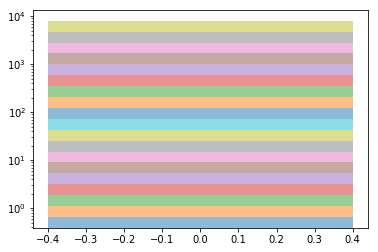

In [88]:
r3 = r2.loc[r2['norm value']>0,'norm value']
bins = np.logspace(np.log10(r3.min()),np.log10(r3.max()),20)
#plt.bar(x=0,bins
for i in range(1,len(bins)):
    plt.bar(x=0,height=bins[i]-bins[i-1],bottom=bins[i-1],log=True,alpha=0.5)
#r3.plot.hist(bins=np.logspace(np.log10(r3.min()),np.log10(r3.max()),20),logx=True)


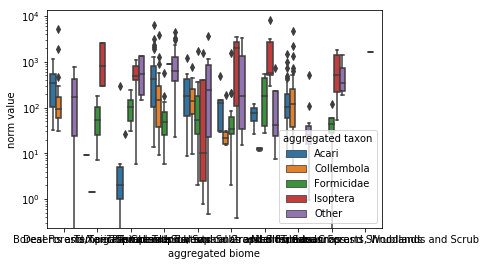

In [46]:
#soil_stacked = soil_biome_means.stack().stack().reset_index()
#sb.violinplot(x='aggregated biome',y=0,hue='aggregated taxon',data=soil_stacked[soil_stacked['level_0']=='mean'])


IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 100

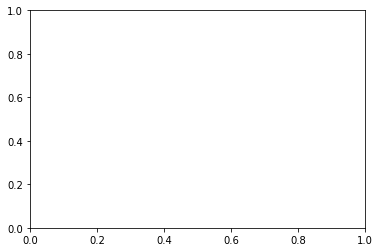

In [21]:
sb.stripplot(x='index',y,soil_biome_means)

In [15]:
soil_biome_means.sum().apply(print_u)

aggregated biome                                              level_0
Boreal Forests/Taiga                                          mean       1093+/-288
                                                              N                  55
Crops                                                         mean       1345+/-292
                                                              N                  22
Deserts and Xeric Shrublands                                  mean       1374+/-nan
                                                              N                  11
Mediterranean Forests, Woodlands and Scrub                    mean         1590+/-0
                                                              N                   2
Pasture                                                       mean       1426+/-329
                                                              N                  30
Temperate Forests                                             mean       3091+/-nan
      

In [20]:
soil_biome_means

aggregated biome Boreal Forests/Taiga                Crops      \
level_0                          mean   N             mean   N   
aggregated taxon                                                 
Acari                 (3.5+/-0.6)e+02  20                0   0   
Collembola            (4.8+/-2.7)e+02  19                0   0   
Formicidae                          0   0          49+/-17   6   
Isoptera                            0   0  (7.5+/-2.2)e+02  10   
Other                 (2.6+/-0.6)e+02  16  (5.5+/-2.0)e+02   6   

aggregated biome Deserts and Xeric Shrublands     \
level_0                                  mean  N   
aggregated taxon                                   
Acari                             9.145+/-nan  1   
Collembola                       1.4325+/-nan  1   
Formicidae                        (7+/-4)e+01  4   
Isoptera                      (1.3+/-0.5)e+03  5   
Other                                       0  0   

aggregated biome Mediterranean Forests, Woodlands and Scrub     \
level_0                                                mean  N   
aggregated taxon                                                 
Acari                                                     0  0   
Collembola                                                0  0   
Formicidae                                                0  0   
Isoptera                                         1590.0+/-0  2   
Other                                                     0  0   

aggregated biome          Pasture     Temperate Forests      \
level_0                      mean  N               mean   N   
aggregated taxon                                              
Acari                 (4+/-4)e+01  7    (7.5+/-1.7)e+02  42   
Collembola                  4+/-4  7    (3.1+/-1.0)e+02  41   
Formicidae               113+/-33  6            81+/-26  21   
Isoptera          (5.6+/-1.9)e+02  5        900.0+/-nan   1   
Other             (7.1+/-2.7)e+02  5  (1.05+/-0.19)e+03  29   

aggregated biome Temperate Grasslands, Savannas and Shrublands      \
level_0                                                   mean   N   
aggregated taxon                                                     
Acari                                          (2.9+/-0.8)e+02  15   
Collembola                                     (1.9+/-0.5)e+02  17   
Formicidae                                     (2.0+/-1.0)e+02  17   
Isoptera                                           (4+/-4)e+02   4   
Other                                          (5.8+/-2.4)e+02  15   

aggregated biome Tropical and Subtropical Forests      \
level_0                                      mean   N   
aggregated taxon                                        
Acari                             (1.6+/-0.8)e+02   5   
Collembola                                49+/-28   6   
Formicidae                        (1.3+/-0.8)e+02  20   
Isoptera                        (1.66+/-0.30)e+03  20   
Other                             (8.4+/-2.9)e+02  15   

aggregated biome Tropical and Subtropical Grasslands, Savannas and Shrublands  \
level_0                                                                  mean   
aggregated taxon                                                                
Acari                                                   (7+/-5)e+01             
Collembola                                               12.4+/-1.0             
Formicidae                                          (2.3+/-0.7)e+02             
Isoptera                                            (1.9+/-0.8)e+03             
Other                                               (2.1+/-1.8)e+02             

aggregated biome               Tundra      
level_0            N             mean   N  
aggregated taxon                           
Acari              2  (1.9+/-0.4)e+02  47  
Collembola         2  (3.9+/-1.5)e+02  34  
Formicidae         9        0.0+/-nan   1  
Isoptera          10        0.0+/-nan   1  
Other              4      (6+/-4)e+01  14

In [16]:
soil_site_data.loc[('Isoptera','Crops')]

site
Sampadi Forest Reserve                                                  204.0
Yurimaguas, Loreto, high input cultivation (corn, first crop)           360.0
Yurimaguas, Loreto, low input cultivation (rice, first crop)           1830.0
Yurimaguas, Loreto, traditional cultivation (first crop of cassava)     270.0
cariniagua research station-crops-cassava                               177.0
cariniagua research station-crops-rice                                   54.0
farmland / settlement (new world)                                      1614.0
farmland / settlement (old world)                                      1614.0
patchy woods + crops / grassland (new world)                            675.0
patchy woods + crops / grassland (old world)                            675.0
Name: norm value, dtype: float64

In [21]:
#t= soil_site_data.reset_index().pivot_table(index='aggregated taxon',columns='aggregated biome',values='norm value', aggfunc='median').T.reset_index()
t= soil_site_data.groupby(['aggregated taxon','aggregated biome']).median().reset_index().merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True)
t.loc[:,'Total'] = (t.loc[:,'norm value']*t.loc[:,'area']).values
(t.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=np.nansum)/1e18).sum(axis=1)


NameError: name 'biome_area1' is not defined

In [22]:
soil_biome_means_unp = soil_site_data.groupby(['aggregated taxon','aggregated biome']).apply(lambda x: unp.uarray(nominal_values= x.mean(),std_devs=x.sem()))
soil_biome_means_unp = soil_biome_means_unp.reset_index()
biome_area = pd.read_csv('data/aggregated biomes data.csv')
biome_area1 = biome_area.groupby('aggregated biome 1')['area'].sum()
biome_area2 = biome_area.groupby('aggregated biome 2')['area'].sum()
# .pivot_table(columns='aggregated taxon',index='aggregated biome')
soil_biome_means_unp1 = soil_biome_means_unp.merge(pd.DataFrame(biome_area1),left_on='aggregated biome',right_index=True)
soil_biome_means_unp2 = soil_biome_means_unp[soil_biome_means_unp['aggregated taxon'].isin(['Formicidae','Isoptera'])]
soil_biome_means_unp2.loc[soil_biome_means_unp2.loc[:,'aggregated biome'].str.contains('Forest'),'aggregated biome'] = 'Forests'
soil_biome_means_unp2.loc[soil_biome_means_unp2.loc[:,'aggregated biome'].str.contains('Grass'),'aggregated biome'] = 'Shrubland/Grassland'
soil_biome_means_unp2 = soil_biome_means_unp2.merge(pd.DataFrame(biome_area2),left_on='aggregated biome',right_index=True)
part1 = soil_biome_means_unp1[soil_biome_means_unp1['aggregated taxon'].isin(['Acari','Collembola','Formicidae','Isoptera','Other'])]
part2 = soil_biome_means_unp2[soil_biome_means_unp2['aggregated taxon'].isin(['Formicidae','Isoptera'])]

In [16]:
part1

,aggregated taxon,aggregated biome,norm value,area
0,Acari,Boreal Forests/Taiga,(3.5+/-0.6)e+02,1.570000e+13
8,Collembola,Boreal Forests/Taiga,(4.8+/-2.7)e+02,1.570000e+13
33,Other,Boreal Forests/Taiga,(2.6+/-0.6)e+02,1.570000e+13
1,Acari,Deserts and Xeric Shrublands,9.145+/-nan,1.960000e+13
9,Collembola,Deserts and Xeric Shrublands,1.4325+/-nan,1.960000e+13
17,Formicidae,Deserts and Xeric Shrublands,(7+/-4)e+01,1.960000e+13
25,Isoptera,Deserts and Xeric Shrublands,(1.3+/-0.5)e+03,1.960000e+13
2,Acari,Pasture,(4+/-4)e+01,2.760000e+13
10,Collembola,Pasture,4+/-4,2.760000e+13
18,Formicidae,Pasture,113+/-33,2.760000e+13


In [23]:
part1.loc[:,'Total'] = (part1.loc[:,'norm value']*part1.loc[:,'area']).values
part1.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=np.nansum)/1e18

aggregated biome,Boreal Forests/Taiga,Crops,Deserts and Xeric Shrublands,Pasture,Temperate Forests,"Temperate Grasslands, Savannas and Shrublands",Tropical and Subtropical Forests,"Tropical and Subtropical Grasslands, Savannas and Shrublands",Tundra
aggregated taxon,,,,,,,,,
Acari,0.0055+/-0.0010,NaN,0.000179242+/-nan,0.0012+/-0.0011,0.0081+/-0.0019,0.0015+/-0.0004,0.0029+/-0.0015,0.0008+/-0.0005,0.00146+/-0.00029
Collembola,0.008+/-0.004,NaN,(2.8077+/-nan)e-05,0.00011+/-0.00011,0.0033+/-0.0011,0.00103+/-0.00026,0.0009+/-0.0005,0.000128+/-0.000010,0.0029+/-0.0011
Formicidae,NaN,0.00075+/-0.00026,0.0014+/-0.0007,0.0031+/-0.0009,0.00087+/-0.00028,0.0011+/-0.0005,0.0023+/-0.0013,0.0024+/-0.0007,0.0+/-nan
Isoptera,NaN,0.0114+/-0.0033,0.025+/-0.010,0.015+/-0.005,0.009684+/-nan,0.0021+/-0.0021,0.029+/-0.005,0.019+/-0.008,0.0+/-nan
Other,0.0041+/-0.0010,0.0084+/-0.0030,NaN,0.020+/-0.007,0.0113+/-0.0021,0.0031+/-0.0013,0.015+/-0.005,0.0021+/-0.0018,0.00048+/-0.00027


In [24]:
u = part1.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=np.nansum)/1e18
print(u['Boreal Forests/Taiga'].sum()*1e3)
u.sum()*1e3

17+/-5


aggregated biome
Boreal Forests/Taiga                                                              17+/-5
Crops                                                                             21+/-4
Deserts and Xeric Shrublands                                    26.930939000000002+/-nan
Pasture                                                                           39+/-9
Temperate Forests                                               33.261603438670754+/-nan
Temperate Grasslands, Savannas and Shrublands                                  8.9+/-2.6
Tropical and Subtropical Forests                                                  50+/-8
Tropical and Subtropical Grasslands, Savannas and Shrublands                      25+/-8
Tundra                                                            4.88679019722328+/-nan
dtype: object

In [286]:
np.sqrt(part1.loc[non_na,'Total'].apply(lambda x: x.std_dev**2).sum())/1e15

19.172639486772447

In [21]:
non_na = ~(part1['Total'].apply(lambda x: x.std_dev).isna())
(part1.loc[non_na,'Total'].sum()+part1.loc[~non_na,'Total'].apply(lambda x: x.nominal_value).sum())/1e18

0.22598581397971507+/-0.019172639486772444

aggregated taxon
Acari         0.021603
Collembola    0.015982
Formicidae    0.011881
Isoptera      0.112580
Other         0.063941
Name: Total, dtype: float64

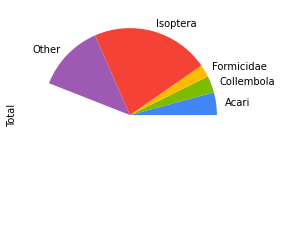

In [31]:
ax = ((part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)/total_soil.nominal_value).plot.pie(colors=['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'])
plt.savefig('results/fig2a.svg', dpi=300)
(part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)


In [65]:
sp_soil_biome_means*

Boreal Forests/Taiga                Crops  \
sub-phylum  aggregated taxon                                             
Chelicerata Acari                 (5.5+/-1.0)e+15                  NaN   
            Other                 (5.8+/-1.4)e+14      (1.5+/-1.0)e+15   
Crustacea   Other                     (9+/-7)e+12  (8.78067+/-nan)e+15   
Hexapoda    Collembola                (8+/-4)e+15                  NaN   
            Formicidae                        NaN      (7.5+/-2.6)e+14   
            Isoptera                          NaN    (1.14+/-0.33)e+16   
            Other                 (3.9+/-1.0)e+15      (3.8+/-0.8)e+15   
Myriapoda   Other                 (6.2+/-1.7)e+14      (1.7+/-1.0)e+15   

                                Deserts and Xeric Shrublands  \
sub-phylum  aggregated taxon                                   
Chelicerata Acari                        (1.79242+/-nan)e+14   
            Other                                        NaN   
Crustacea   Other                                        NaN   
Hexapoda    Collembola        (2.8077000000000005+/-nan)e+13   
            Formicidae                       (1.4+/-0.7)e+15   
            Isoptera                         (2.5+/-1.0)e+16   
            Other                                        NaN   
Myriapoda   Other                                        NaN   

                             Mediterranean Forests, Woodlands and Scrub  \
sub-phylum  aggregated taxon                                              
Chelicerata Acari                                                   NaN   
            Other                                                   NaN   
Crustacea   Other                                                   NaN   
Hexapoda    Collembola                                              NaN   
            Formicidae                                              NaN   
            Isoptera                                            nan+/-0   
            Other                                                   NaN   
Myriapoda   Other                                                   NaN   

                                      Pasture  Temperate Forests  \
sub-phylum  aggregated taxon                                       
Chelicerata Acari             (1.2+/-1.1)e+15    (8.1+/-1.9)e+15   
            Other             (1.7+/-0.9)e+15    (7.5+/-1.3)e+14   
Crustacea   Other                         NaN    (3.1+/-1.2)e+14   
Hexapoda    Collembola        (1.1+/-1.1)e+14    (3.3+/-1.1)e+15   
            Formicidae        (3.1+/-0.9)e+15    (8.7+/-2.8)e+14   
            Isoptera          (1.5+/-0.5)e+16  (9.684+/-nan)e+15   
            Other             (1.3+/-0.5)e+16    (5.0+/-0.8)e+15   
Myriapoda   Other             (5.0+/-2.1)e+15    (6.3+/-1.8)e+15   

                             Temperate Grasslands, Savannas and Shrublands  \
sub-phylum  aggregated taxon                                                 
Chelicerata Acari                                          (1.5+/-0.4)e+15   
            Other                                          (1.1+/-0.4)e+14   
Crustacea   Other                                          (5.4+/-2.8)e+14   
Hexapoda    Collembola                                   (1.03+/-0.26)e+15   
            Formicidae                                     (1.1+/-0.5)e+15   
            Isoptera                                       (2.1+/-2.1)e+15   
            Other                                          (1.0+/-0.9)e+16   
Myriapoda   Other                                          (2.2+/-0.7)e+15   

                             Tropical and Subtropical Forests  \
sub-phylum  aggregated taxon                                    
Chelicerata Acari                             (2.9+/-1.5)e+15   
            Other                             (2.9+/-1.3)e+15   
Crustacea   Other                             (6.2+/-3.2)e+14   
Hexapoda    Collembola                            (9+/-5)e+14   
            Formicidae                      

sub-phylum
Chelicerata      0.127+/-0.015
Crustacea      0.0063+/-0.0019
Hexapoda           0.77+/-0.09
Myriapoda        0.092+/-0.017
dtype: object

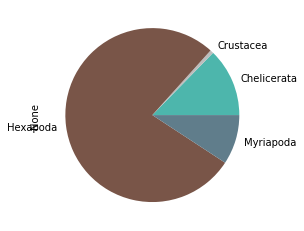

In [26]:
sp_soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','sub-phylum','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
sp_soil_site_data = sp_soil_site_taxa_mean.groupby(['aggregated taxon','sub-phylum','aggregated biome','site'])['norm value'].sum()
sp_soil_biome_means = sp_soil_site_data.reset_index().pivot_table(index=['sub-phylum','aggregated taxon'],columns='aggregated biome',values='norm value', aggfunc=calc_uval)
sp_soil_biome_means = sp_soil_biome_means.drop('Mixed')
# area = biome_area.set_index('aggregated biome 1').loc[sp_soil_biome_means.columns,'area']
## new addition
area = biome_area.set_index('aggregated biome 1').merge(sp_soil_biome_means.T,left_index=True,right_index=True)['area']
area = area.reset_index().groupby('index').sum()['area']
##
tot_sp = (sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum).sum()

ax = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value).apply(lambda x: x.nominal_value).plot.pie(colors=['#4db6ac','#bdbdbd','#795548','#607d8b'])
# plt.savefig('results/fig2b.svg', dpi=300)
((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value)

matplotlib.axes._subplots.AxesSubplot

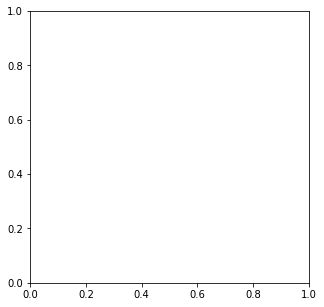

In [104]:
fig,ax = plt.subplots(figsize=[5,5])
type(ax)

In [141]:
group_sum.sort_values(ascending=False)

isoptera\n(termites)         0.112580
other                        0.063941
acari\n(mites)               0.021603
collembola\n(springtails)    0.015982
formicidae\n(ants)           0.011881
Name: Total, dtype: float64

Text(-1, 0.21, 'B')

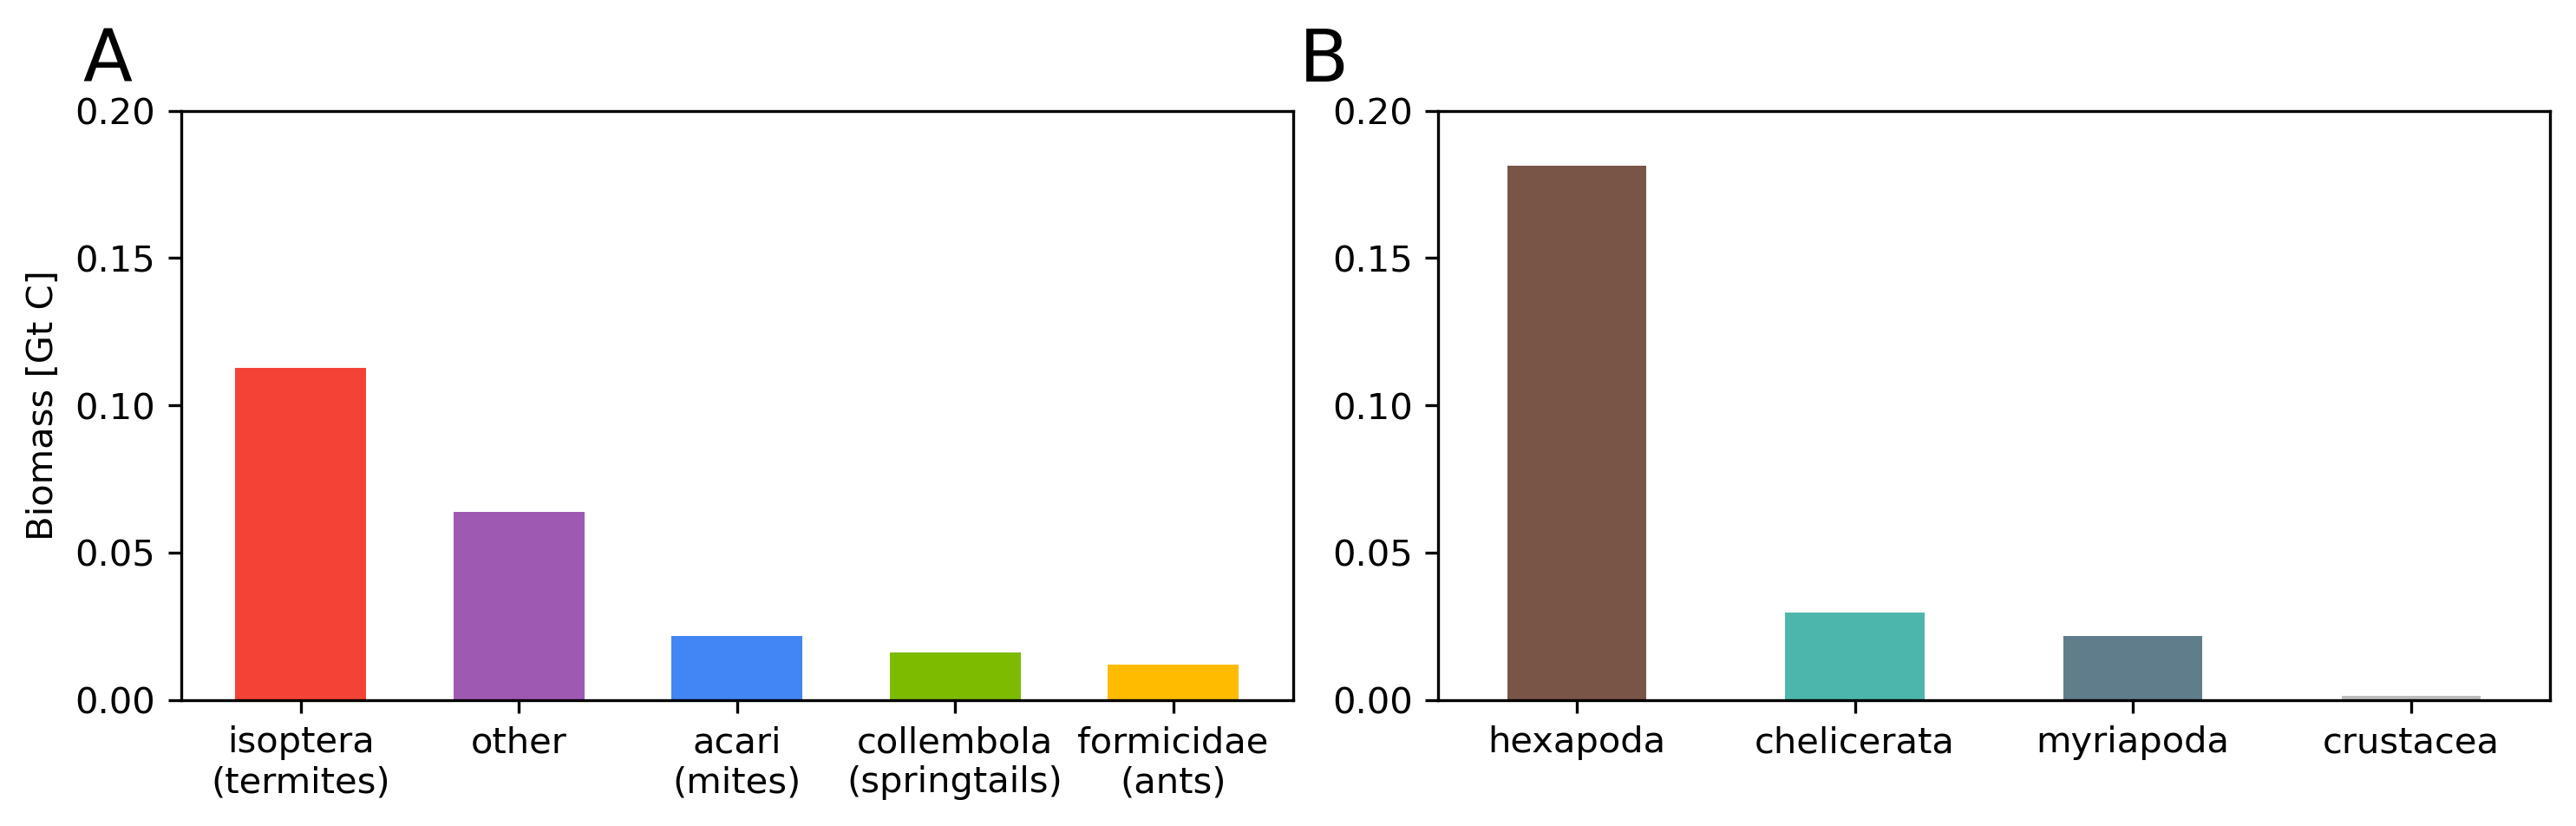

In [30]:
fig,ax = plt.subplots(1,2,figsize=[10,3],dpi=300)
ax = plt.subplot(1,2,1)
group_sum = ((part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value))
group_sum.index = ['acari\n(mites)','collembola\n(springtails)','formicidae\n(ants)','isoptera\n(termites)','other']
group_colors = pd.Series(['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],index = group_sum.index)
group_sum.sort_values(ascending=False,inplace=True)

group_sum.sort_values(ascending=False).plot.bar(width = 0.6,color=group_colors.loc[group_sum.index],rot=0,ax=ax)
# ((part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)).plot.bar(colors=['#4285F4','#7CBB00','#FFBB00','#f44336','#9e59b3'],rot=45,ax=ax)
ax.set_ylabel('Biomass [Gt C]')

# (part1.groupby('aggregated taxon').Total.sum()/1e18).apply(lambda x: x.nominal_value)
ax2 = plt.subplot(1,2,2)
subphyla_sum = ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/1e18).apply(lambda x: x.nominal_value)
subphyla_sum.index = ['chelicerata','crustacea','hexapoda','myriapoda']
subphyla_colors = pd.Series(['#4db6ac','#bdbdbd','#795548','#607d8b'],index = subphyla_sum.index)
subphyla_sum.sort_values(ascending=False,inplace=True)
subphyla_sum.plot.bar(width = 0.5,color=subphyla_colors.loc[subphyla_sum.index],ax=ax2,rot=0)
ax.set_ylim([0,0.2])
ax2.set_ylim([0,0.2])
ax.set(yticks=np.arange(0,0.25,0.05))
ax2.set(yticks=np.arange(0,0.25,0.05))
# ax.set_ylabel('Biomass [Gt C]')
# plt.savefig('results/fig2b.svg', dpi=300)
plt.tight_layout()
ax.text(-1,0.21,'A',fontdict={'size':20})
ax2.text(-1,0.21,'B',fontdict={'size':20})
# plt.savefig('results/fig2.svg', dpi=300)
# plt.savefig('results/fig2.png', dpi=300)

# plt.savefig('results/fig2b.svg', dpi=300)
# ((sp_soil_biome_means*area).groupby('sub-phylum').apply(np.nansum)/tot_sp.nominal_value)


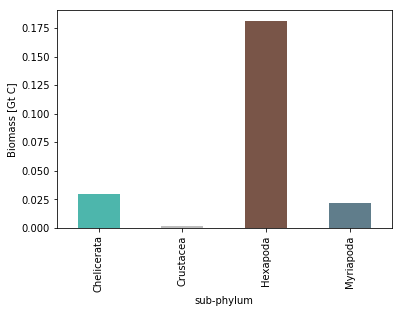

In [23]:
ar_soil_site_taxa_mean = soil_data.groupby(['aggregated taxon','order','aggregated biome','site','taxon'])['norm value'].mean().reset_index()
ar_soil_site_data = ar_soil_site_taxa_mean.groupby(['aggregated taxon','order','aggregated biome','site'])['norm value'].sum()
ar_soil_biome_means = ar_soil_site_data.reset_index().pivot_table(index=['order'],columns='aggregated biome',values='norm value', aggfunc=calc_uval)
# ar_soil_site_data.reset_index().set_index('order').loc['Araneae']
(ar_soil_biome_means.loc['Araneae']*area).sum()/1e18
ar_soil_biome_means.loc['Araneae']

aggregated biome
Boreal Forests/Taiga                                               59+/-14
Crops                                                           51.0+/-nan
Deserts and Xeric Shrublands                                           NaN
Mediterranean Forests, Woodlands and Scrub                             NaN
Pasture                                                                NaN
Temperate Forests                                                  65+/-12
Temperate Grasslands, Savannas and Shrublands                       21+/-7
Tropical and Subtropical Forests                                   36+/-14
Tropical and Subtropical Grasslands, Savannas and Shrublands       28+/-21
Tundra                                                              18+/-5
Name: Araneae, dtype: object

In [23]:
# total_soil = (part1.groupby('aggregated taxon').Total.sum()/1e18).sum()
non_na = ~(part1['Total'].apply(lambda x: x.std_dev).isna())
total_soil =  (part1.loc[non_na,'Total'].sum()+part1.loc[~non_na,'Total'].apply(lambda x: x.nominal_value).sum())/1e18
total_soil

0.22598581397971507+/-0.019172639486772444

In [25]:
part2 = part2[part2['aggregated biome']!='Tundra']
part2.loc[:,'Total'] = (part2.loc[:,'norm value']*part2.loc[:,'area']).values
part2.pivot_table(values='Total',index='aggregated taxon',columns='aggregated biome',aggfunc=sum)/1e18

aggregated biome,Forests,Shrubland/Grassland
aggregated taxon,,
Formicidae,0.009+/-0.004,0.015+/-0.004
Isoptera,0.18288723685612154+/-nan,0.080+/-0.031


In [386]:
part2.groupby('aggregated taxon').Total.sum()/1e18

aggregated taxon
Formicidae                0.036+/-0.007
Isoptera      0.28914764157651207+/-nan
Name: Total, dtype: object

In [26]:
total_soil = (part1.Total.sum()+part2.Total.sum())/1e18

In [44]:
canopy_site_taxa_mean = canopy_data.groupby(['aggregated biome','site','taxon'])['norm value'].mean().reset_index()
canopy_site_data = canopy_site_taxa_mean.groupby(['aggregated biome','site'])['norm value'].sum()
canopy_biome_means = canopy_site_data.reset_index().pivot_table(index='aggregated biome',values='norm value', aggfunc=[calc_uval,'count'])

canopy_biome_means = canopy_biome_means.droplevel(axis=1,level=0)
canopy_biome_means.columns = ['mean','N']


def print_u(x):
    if type(x) != uncertainties.core.Variable:
        return '{:.0f}'.format(x )
    else: 
        return '{:.0f}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

canopy_biome_means_print = canopy_biome_means.applymap(print_u)
#soil_biome_means_print.to_csv('results/table_1.csv')
canopy_biome_means_print

/home/yinonbaron/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,mean,N
aggregated biome,,
Boreal Forests/Taiga,154±23,6
"Mediterranean Forests, Woodlands and Scrub",182±nan,1
Temperate Forests,230±63,4
Tropical and Subtropical Forests,458±382,4


In [47]:
total_canopy = np.nansum(canopy_biome_means['mean']*area)/1e18
total_canopy

0.012980643707+/-0.006779288674337382

In [155]:
surface_site_taxa_mean = surface_data.groupby(['aggregated biome','site','taxon'])['norm value'].mean().reset_index()
surface_site_data = surface_site_taxa_mean.groupby(['aggregated biome','site'])['norm value'].sum()
surface_biome_means = surface_site_data.reset_index().pivot_table(index='aggregated biome',values='norm value', aggfunc=[calc_uval,'count'])

surface_biome_means = surface_biome_means.droplevel(axis=1,level=0)
surface_biome_means.columns = ['mean','N']


def print_u(x):
    if type(x) != uncertainties.core.Variable:
        return '{:.0f}'.format(x )
    else: 
        return '{:.0f}'.format(x.nominal_value)+'±'+'{:.0f}'.format(x.std_dev)

surface_biome_means_print = surface_biome_means.applymap(print_u)
#soil_biome_means_print.to_csv('results/table_1.csv')
surface_biome_means_print

,mean,N
aggregated biome,,
Crops,114±21,17
Deserts and Xeric Shrublands,485±283,2
Pasture,15±15,2
"Temperate Grasslands, Savannas and Shrublands",5298±2737,4


In [49]:
total_surface = np.nansum(surface_biome_means['mean']*area)/1e18
total_surface

0.040415192019706+/-0.015869214574475873

In [558]:
surface_biome_mean = surface_data.groupby(['aggregated biome','site'])['numerical value'].sum().groupby('aggregated biome').agg(['mean','sem'])
surface_biome_mean = surface_biome_mean.merge(pd.DataFrame(biome_area1),left_index=True,right_index=True)
surface_biome_mean['unp']=unp.uarray(nominal_values=surface_biome_mean['mean'],std_devs=surface_biome_mean['sem'])
surface_biome_mean['Total'] = surface_biome_mean.unp*surface_biome_mean.area
surface_biome_mean.Total/1e18

Crops                                            0.0062+/-0.0014
Deserts and Xeric Shrublands                       0.027+/-0.023
Pasture                                          0.0004+/-0.0004
Temperate Grasslands, Savannas and Shrublands        0.10+/-0.05
Name: Total, dtype: object

In [85]:
total_surface = surface_biome_mean.Total.sum()/1e18
total_surface

NameError: name 'surface_biome_mean' is not defined

In [51]:
overall_biomass = total_surface+total_canopy+total_soil
overall_biomass

0.2793816497064211+/-0.025794976856560705

,0
Soil,0.808879
Canopy,0.046462
Aboveground,0.144659


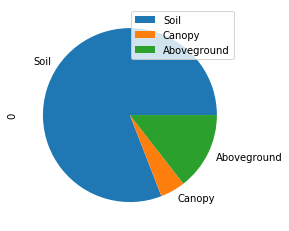

In [84]:


(pd.DataFrame([total_soil.nominal_value,total_canopy.nominal_value,total_surface.nominal_value],index=['Soil','Canopy','Aboveground'])/overall_biomass.nominal_value).plot.pie(y=0)
(pd.DataFrame([total_soil.nominal_value,total_canopy.nominal_value,total_surface.nominal_value],index=['Soil','Canopy','Aboveground'])/overall_biomass.nominal_value)

In [74]:
total_surface+total_canopy+total_soil

0.2793816497064211+/-nan

In [24]:
print(canopy_data.site.nunique())
print(surface_data.site.nunique())

14
18


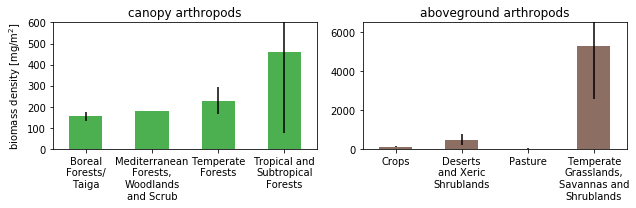

In [284]:
canopy_biome_means_bar = canopy_biome_means.copy()
ind = canopy_biome_means_bar.index.values
ind[0] = 'Boreal\nForests/\nTaiga'
ind[1] = 'Mediterranean\nForests,\nWoodlands\nand Scrub'
ind[2] = 'Temperate\nForests'
ind[3] = 'Tropical and\nSubtropical\nForests'
canopy_biome_means_bar.index = ind

surface_biome_means_bar = surface_biome_means.copy()
ind2 = surface_biome_means_bar.index.values

ind2[1] = 'Deserts\nand Xeric\nShrublands'
ind2[3] = 'Temperate\nGrasslands,\nSavannas and\nShrublands'
surface_biome_means_bar.index = ind2

fig = plt.subplots(figsize=[9,3])
ax = plt.subplot(1,2,1)
canopy_biome_means_bar['mean'].apply(lambda x: x.nominal_value).plot.bar(yerr=canopy_biome_means['mean'].apply(lambda x: x.std_dev),colors=['#4caf50'],rot=0,ax=ax)
ax.set_ylabel('biomass density [mg/m$^2$]')
ax.set_title('canopy arthropods')
ax.set_ylim([0,600])

ax2 = plt.subplot(1,2,2)
surface_biome_means_bar['mean'].apply(lambda x: x.nominal_value).plot.bar(yerr=surface_biome_means['mean'].apply(lambda x: x.std_dev),colors=['#8d6e63'],rot=0,ax=ax2)
ax.set_ylabel('biomass density [mg/m$^2$]')
ax2.set_title('aboveground arthropods')
ax2.set_ylim([0,6500])
plt.tight_layout()
plt.savefig('results/fig3.svg',dpi=300)
plt.savefig('results/fig3.png',dpi=300)

In [218]:
site_units = mass_data.groupby('site').units.nunique()
cal_data=mass_data[mass_data.site.isin(site_units[site_units==2].index)]
cal_pvt = cal_data.pivot_table(index=['site','taxon'],columns='units',values='numerical value',aggfunc=np.nanmean)
conv_ratios = (cal_pvt['mg/m^2 (dry weight)']/cal_pvt['mg/m^2 (wet weight)']).reset_index()
print(conv_ratios[conv_ratios.site.str.startswith('Cow')].mean())
print(conv_ratios[conv_ratios.site.str.startswith('Cow')].sem())

0    0.316134
dtype: float64
0    0.074895
dtype: float64
